# The purpose of this notebook is to be able to work on other things while grid searches are running. The order things are done in this notebook likely make no sense. 

In [1]:
# import our libraries

import pandas as pd
import numpy as np
import re
import textwrap

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.experimental import enable_hist_gradient_boosting, enable_halving_search_cv
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, HalvingRandomSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, \
VotingClassifier, HistGradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from xgboost import XGBClassifier

from collections import Counter
from googletrans import Translator, LANGUAGES

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create a dataframe with train and test scores of our models
model_score = pd.DataFrame({'model': ['Baseline', 'Count Vectorizer Logistic Regression', 'TFIDF Logistic Regression',
                                     'Count Vectorizer Naive Bayes', 'TFIDF Naive Bayes', 
                                     'Count Vectorizer K-Nearest Neighbors', 'TFIDF K-Nearest Neighbors', 
                                     'Count Vectorizer Random Forest', 'TFIDF Random Forest', 
                                     'Count Vectorizer XGBoost', 'TDIDF XGBoost', 
                                     'Count Vectorizer Support Vector Machine', 'TFIDF Support Vector Machine'] * 2,
                           'train/test': ['train' if i <= 12 else 'test' for i in range(26)],
                           'score': [0.55, 0.711, 0.667, 0.690, 0.707, 0.603, 0.681, 0.706, 0.711, 0.708, 0.698, 0.573, 0.715,
                                    0.55, 0.721, 0.678, 0.696, 0.720, 0.596, 0.683, 0.722, 0.723, 0.712, 0.703, 0.586, 0.723]})

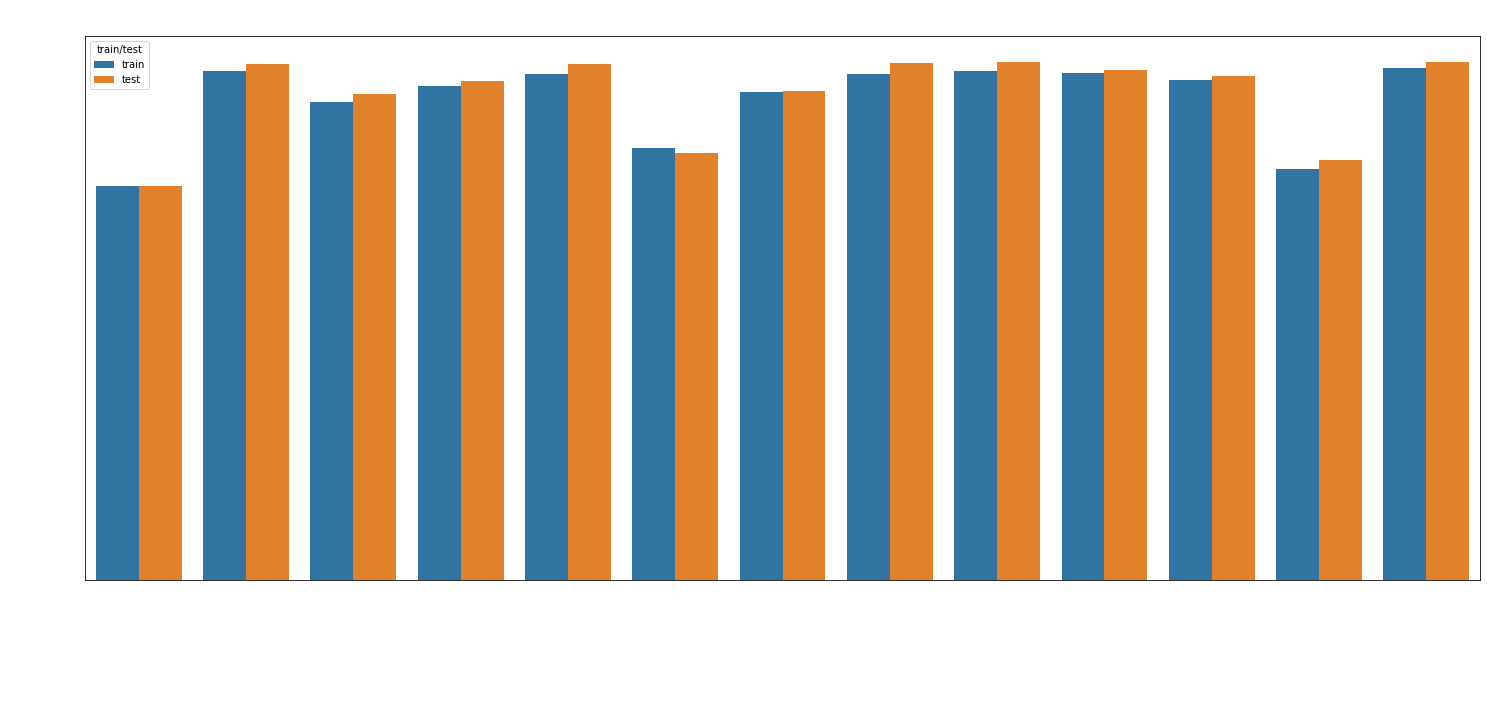

In [17]:
# create bar chart from our dataframe
max_width = 10
plt.figure(figsize = (25, 10))
plt.title('Model Accuracy Scores', fontsize = 30, fontweight = 'bold', color = 'white')
ax = sns.barplot(y = model_score['score'], x = model_score['model'], hue = model_score['train/test'])
ax.set_xticklabels(textwrap.fill(x.get_text(), max_width) for x in ax.get_xticklabels())
ax.yaxis.set_tick_params(labelsize = 30, colors = 'white')
ax.xaxis.set_tick_params(labelsize = 20, colors = 'white')
ax.set_ylabel('score', fontsize = 20, color = 'white')
ax.set_xlabel('model', fontsize = 15, color = 'white')
plt.savefig('../images/accuracy_scores.png');

In [18]:
# import dataset

translated_df = pd.read_csv('../data/translated.csv')
translated_df.head()

,subreddit,merged_text
0,1,Fix to not being able to attack? Has anybody f...
1,1,Attack glitch during Regi raids 2 raids today ...
2,1,[Bug?] Can’t seem to earn or collect pokecoins...
3,1,"[Bug?] AR suddenly freezes Using an iPhone 11,..."
4,1,3 hour incense event personal results For any ...


In [19]:
# remove duplicate entries where text is the same
translated_df = translated_df.drop_duplicates('merged_text')

In [20]:
# thanks to Hov
# instantiate the sentiment analyzer
sia = SentimentIntensityAnalyzer()
def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

translated_df['sentiment'] = translated_df['merged_text'].apply(get_compound_sentiment)

In [21]:
get_text_data = FunctionTransformer(lambda x: x['merged_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['sentiment']], validate = False)

In [22]:
# create train_test_split to evaluate our baseline model
X = translated_df[['merged_text', 'sentiment']]
y = translated_df['subreddit']

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

# create predictions for train and test set
y_train_preds = np.full_like(y_train, 1)
y_test_preds = np.full_like(y_test, 1)

print(f'Baseline accuracy on training data: {round(accuracy_score(y_train, y_train_preds), 2)}')
print(f'Baseline accuracy on testing data: {round(accuracy_score(y_test, y_test_preds), 2)}')

Baseline accuracy on training data: 0.55
Baseline accuracy on testing data: 0.55


In [24]:
# create a custom stop words list to remove all similar words we found in the previous notebook

# start with the base english stopwords
new_stopwords = stopwords.words('english')

# add stopwords that will easily identify a silph post
# also added stopwords that are common across both subreddits and stop words as a result and lemmatizing and stemming
custom_words = ['silph', 'road', 'silphroad', 'thesilphroad', 'pokemon', 'go', 'get', 'one', 'like', 'would', 'know', 'time', 'game', 'shiny', 
               'https', 'raid', 'anyone', 'got', 'new', 'event', 'day', 'level', 'even', 'com', 'raids', 'still', 'people', 'also', 'since',
               'use', 'catch', 'amp', 'see', 'want', 'could', 'first', 'research', 'shadow', 'think', 'else', 'way', 'niantic', 'make', 
               'back', 'really', 'need', 'eggs', 'community', 'something', 'much', 'good', 'able', "'d", "'ll", "'re", "'s", "'ve", 'abl', 
                'abov', 'ani', 'anyon', 'becaus', 'befor', 'commun', 'doe', 'dure', 'egg', 'els', 'ha', 'hi', 'http', 'might', 'must', 
                "n't", 'onc', 'onli', 'ourselv', 'peopl', 'realli', 'sha', 'shini', 'sinc', 'someth', 'themselv', 'thi', 'veri', 'wa', 
                'whi', 'wo', 'yourselv', 'becau', 'el']

new_stopwords.extend(custom_words)

In [25]:
# custom preprocessing of text 
# thanks to the following article for the code: https://kavita-ganesan.com/how-to-use-countvectorizer/#CountVectorizer-Plain-and-Simple

lemmatizer = WordNetLemmatizer()
def lemma_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

porter_stemmer = PorterStemmer()
def stem_preprocessor(text):
    text = text.lower()
    text = re.sub("\\W", " ", text) # remove special characters
    text = re.sub("\\s+(in|the|all|for|and|on)\\s+"," _connector_ ", text) # normalize certain words
    
    #stem words
    words = re.split("\\s+", text)
    stemmed_words = [porter_stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [28]:
# create logistic regression pipeline using best params from earlier gridsearch
cvec_sentiment_pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words = new_stopwords, strip_accents = 'unicode', 
                                        preprocessor = lemma_preprocessor, ngram_range = (1,1), 
                                        min_df = 3, max_features = 53400, max_df = 0.822222))
            ]))
    ])),
    ('densify', FunctionTransformer(lambda x: x.todense(), accept_sparse=True)),
    ('logr', LogisticRegression(penalty = 'l2', C = 0.04313873873873874))
])

In [29]:
cvec_sentiment_pipe.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('numeric_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f3e4ae36670>)),
                                                                 ('ss',
                                                                  StandardScaler())])),
                                                ('text_features',
                                                 Pipeline(steps=[('selector',
                                                                  FunctionTransformer(func=<function <lambda> at 0x7f3e4afc9160>)),
                                                                 ('cvec',
                                                                  CountVectorizer(max_df=0.822222,
                                                                                  m

In [35]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [36]:
# build a function to print out a nice confusion matrix
preds = cvec_sentiment_pipe.predict(X_test)

nice_conmat(y_test, preds, ['pokemongo', 'TheSilphRoad'])

Accuracy Score: 0.7089067774603999


,Predicted pokemongo,Predicted TheSilphRoad
Actual pokemongo,1080,649
Actual TheSilphRoad,472,1650
